In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [ ]:
df = pd.read_csv('/content/Churn_Modelling.csv')
df.shape

(10000, 14)

In [ ]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.isnull().sum()

,0
RowNumber,0
CustomerId,0
Surname,0
CreditScore,0
Geography,0
Gender,0
Age,0
Tenure,0
Balance,0
NumOfProducts,0


In [ ]:
df.nunique()

,0
RowNumber,10000
CustomerId,10000
Surname,2932
CreditScore,460
Geography,3
Gender,2
Age,70
Tenure,11
Balance,6382
NumOfProducts,4


The first two attributes will be excluded as they are specific to individual customers. Additionally, the surname attribute will be excluded to avoid any potential for profiling.

In [ ]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [ ]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.dtypes

,0
CreditScore,int64
Geography,object
Gender,object
Age,int64
Tenure,int64
Balance,float64
NumOfProducts,int64
HasCrCard,int64
IsActiveMember,int64
EstimatedSalary,float64


In [ ]:
# class imbance check
unique_values_counts_churn = df['Exited'].value_counts()

print(unique_values_counts_churn)

df.duplicated().sum()

Exited
0    7963
1    2037
Name: count, dtype: int64


0

In [ ]:
# one hot encoding
categorical_columns = ['Geography' , 'Gender']

data = pd.get_dummies(df, columns=categorical_columns, dtype=int)

In [ ]:
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


# EDA

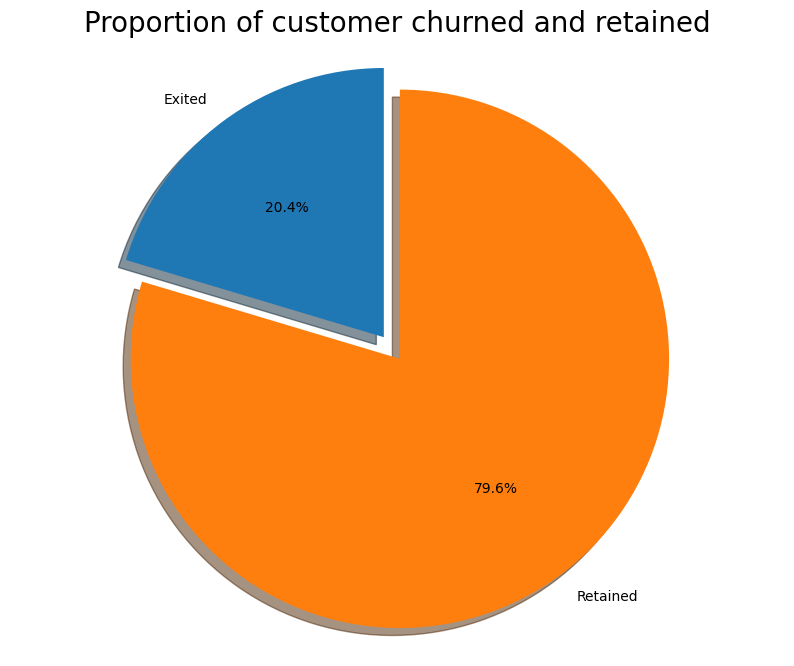

In [ ]:
labels = 'Exited', 'Retained'
sizes = [data.Exited[data['Exited']==1].count(), data.Exited[data['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def plot_heatmap(df, drop_columns=[], figsize=(20, 10)):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Drop specified columns and select only numeric data
    filtered_df = df.drop(columns=drop_columns).select_dtypes(include=['number'])

    # Ensure there are numeric columns left
    if filtered_df.empty:
        raise ValueError("No numeric columns left after filtering. Check your data and drop_columns.")

    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(filtered_df.corr(), annot=True, fmt=".3f", cmap="viridis")
    plt.title("Correlation Heatmap")
    plt.show()

def plot_feature_correlation(df, target_column):

    # Ensure numeric data only
    numeric_df = df.select_dtypes(include=['number'])

    # Check if target column exists in numeric data
    if target_column not in numeric_df.columns:
        raise ValueError(f"Target column '{target_column}' is not numeric or not present in the DataFrame.")

    # Compute correlations
    correlations = numeric_df.corr()[target_column].sort_values(ascending=False)

    # Plot the correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlations.index, y=correlations.values)
    plt.title(f'Correlation with {target_column}')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(rotation=45)  # Rotate x-axis labels
    plt.savefig('corr.png')
    plt.show()

def plot_boxplots(df, columns):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    plt.subplots_adjust(hspace=0.5)

    for i, col in enumerate(columns):
        sns.boxplot(x="Exited", y=col, data=df, ax=axes[i//2, i%2])
        axes[i//2, i%2].set_title(col.capitalize() + " by Churn")

    plt.tight_layout()
    plt.savefig('boxes.png')
    plt.show()

def plot_distribution(df, columns):
    for col in columns:
        plt.figure(figsize=(8, 6))  # Set figure size for clarity
        g = sns.histplot(df[col], kde=True, color="b", label="Skewness: %.2f" % (df[col].skew()))  # Updated to `histplot`
        plt.legend(loc="best")
        plt.title("Distribution of " + col.capitalize())
        plt.xlabel(col.capitalize())
        plt.ylabel("Frequency")
        filename = f'distribution_{col.lower()}.png'  # Create a unique filename for each plot
        plt.savefig(filename)
        plt.show()

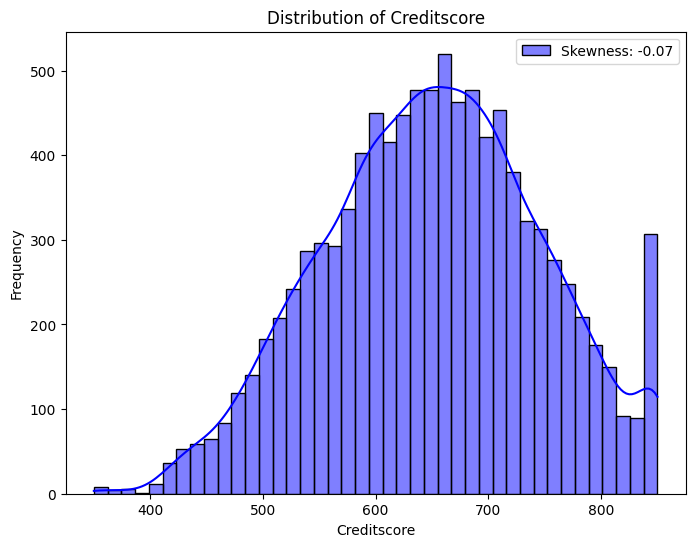

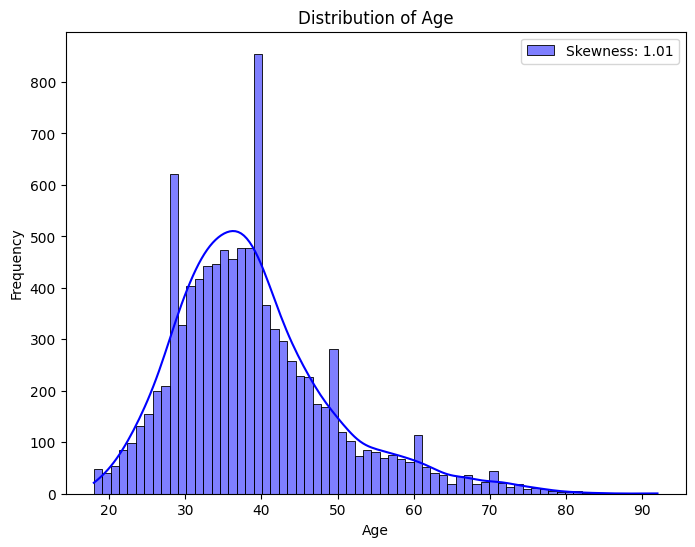

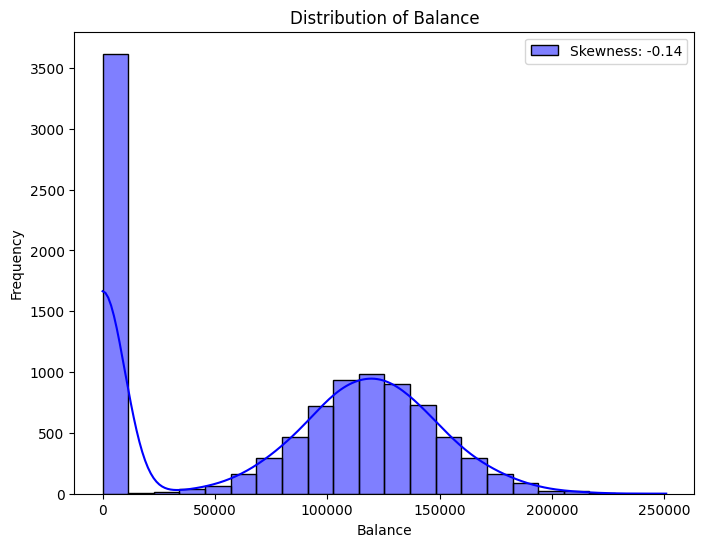

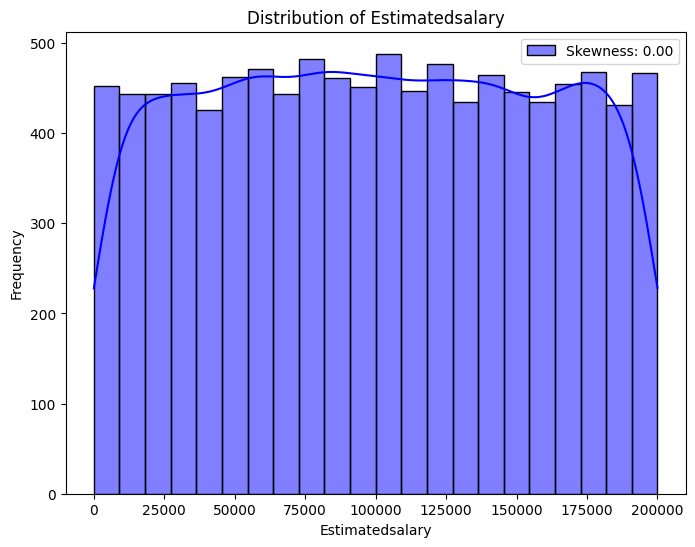

In [ ]:
columns_to_plot = ["CreditScore", "Age", "Balance", "EstimatedSalary"]
plot_distribution(df, columns_to_plot)

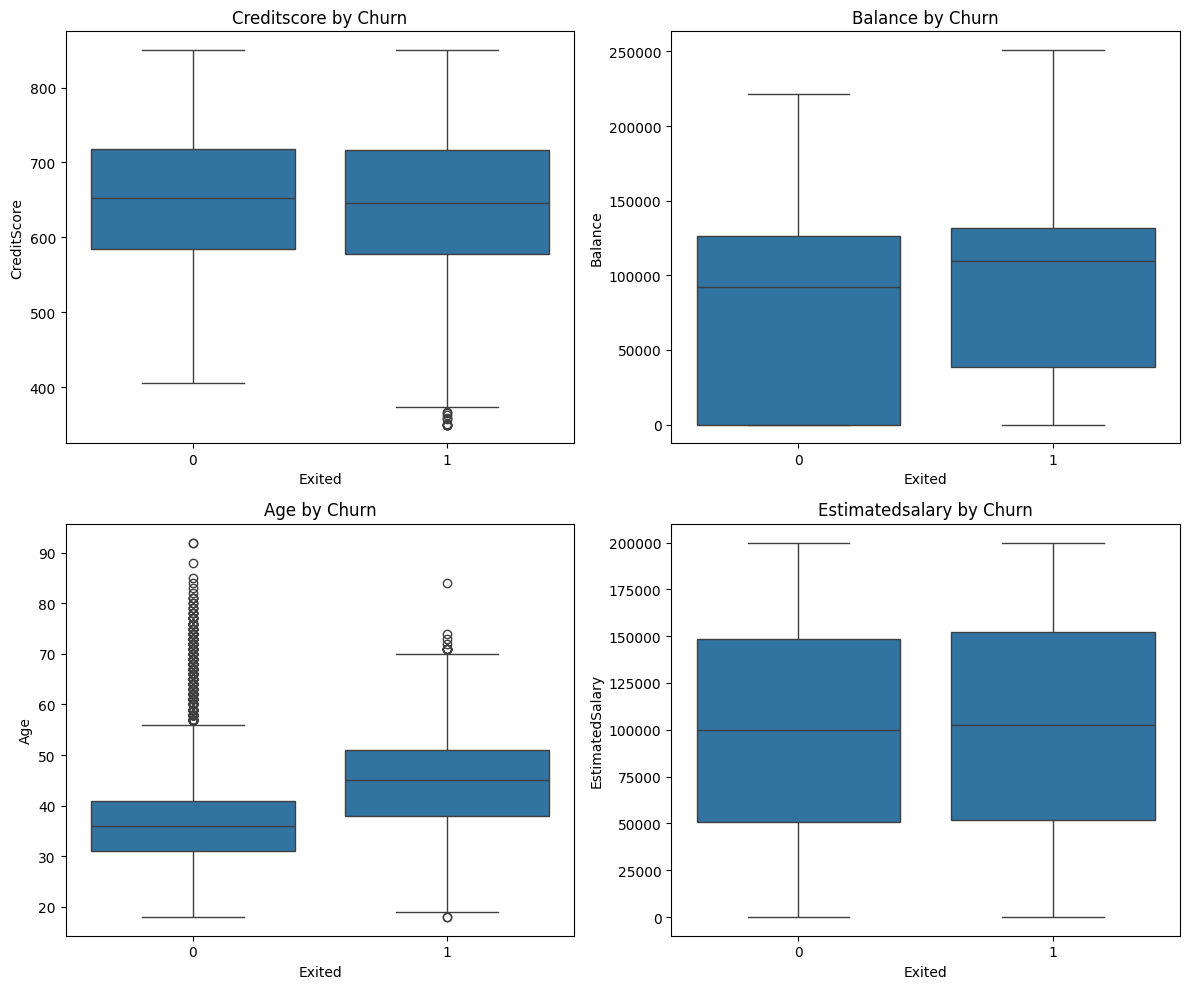

In [ ]:
columns_to_plot = ["CreditScore", "Balance", "Age", "EstimatedSalary"]
plot_boxplots(df, columns_to_plot)

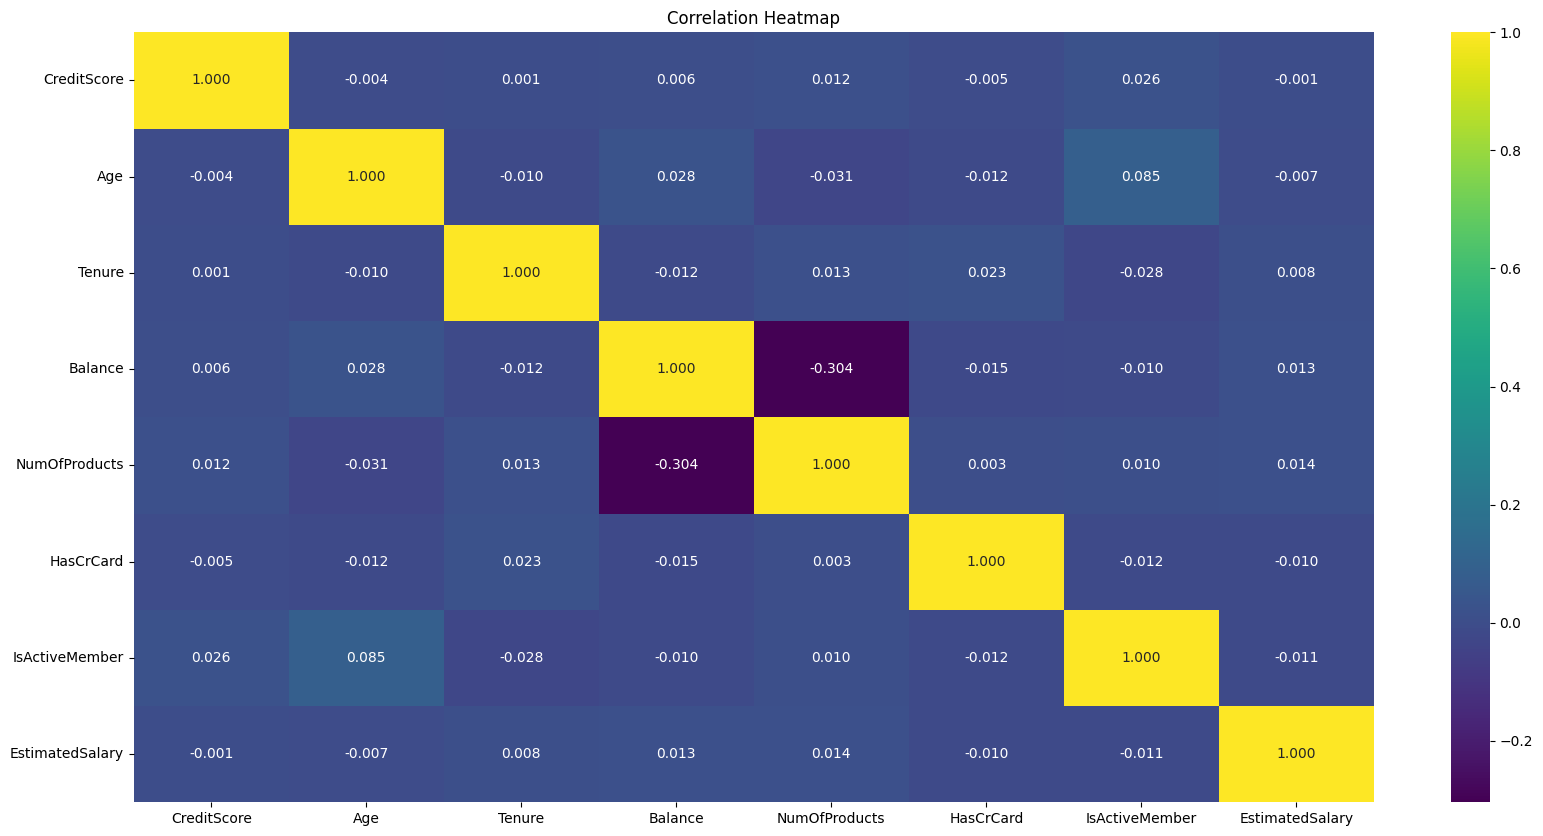

In [ ]:
plot_heatmap(df, drop_columns=['Exited'])


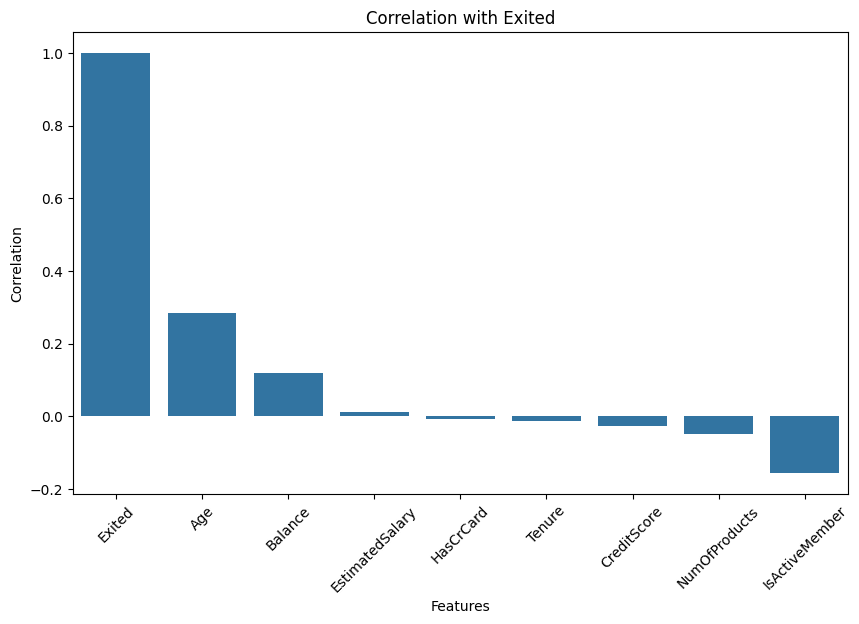

In [ ]:
plot_feature_correlation(df, 'Exited')


## Data Preparation and Model fitting




In [ ]:
# split feature data and target data
y = data['Exited']
x = data.drop('Exited', axis=1)

In [ ]:
# logic for sampling and splitting the data
def sampling(X, y, test_size=0.5):
      data = pd.concat([X, y], axis=1)
      data_1 = data[data['Exited'] == 1]
      data_0 = data[data['Exited'] == 0]

      y_1 = data_1['Exited']
      X_1 = data_1.drop('Exited', axis=1)

      y_0 = data_0['Exited']
      X_0 = data_0.drop('Exited', axis=1)

      X_1_sample = X_1.sample(n=1000, random_state=42)
      y_1_sample = y_1.loc[X_1_sample.index]

      X_0_sample = X_0.sample(n=1000, random_state=42)
      y_0_sample = y_0.loc[X_0_sample.index]

      X_sample = pd.concat([X_1_sample, X_0_sample])

      y_sample = pd.concat([y_1_sample, y_0_sample])

      # stratified sampling
      X_val, X_test, y_val, y_test = train_test_split(X_sample, y_sample, test_size = test_size, stratify=y_sample, random_state=42)


      indices_X_1_remaining = X_1.index.difference(X_1_sample.index)

      indices_X_0_remaining = X_0.index.difference(X_0_sample.index)

      X_1_remaining = X_1.loc[indices_X_1_remaining]
      y_1_remaining = y_1.loc[indices_X_1_remaining]

      X_0_remaining = X_0.loc[indices_X_0_remaining]
      y_0_remaining = y_0.loc[indices_X_0_remaining]

      X_train = pd.concat([X_1_remaining, X_0_remaining])
      y_train = pd.concat([y_1_remaining, y_0_remaining])

      print(f'X_val shape is {X_val.shape}')
      print(f'X_test shape is {X_test.shape}')
      print(f'X_train shape is {X_train.shape}')

      return X_val, X_test, X_train, y_val, y_test, y_train

In [ ]:
# train, test, validation split
X_val, X_test, X_train, y_val, y_test, y_train = sampling(X,y)

X_val shape is (1000, 13)
X_test shape is (1000, 13)
X_train shape is (8000, 13)


In [ ]:
# Standardized Scaler
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])

X_val[X_val.columns] = scaler.fit_transform(X_val[X_val.columns])

X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [ ]:
# class imbalance resampling
smote = SMOTE()
X_train,y_train = smote.fit_resample(X_train,y_train)
print(Counter(y_train))

Counter({1: 6963, 0: 6963})


In [ ]:
def compute_f1_score(model, x_data, labels):
  pred_y = model.predict(x_data)
  return f1_score(labels, pred_y)


def compute_roc_auc_score(model, x_data, labels):
  pred_y = model.predict_proba(x_data)[:, 1]
  return roc_auc_score(labels, pred_y)

Logistic Regression

In [ ]:
# Logistic regression
lr = LogisticRegression()

lr.fit(X_train, y_train)

# f1 scores
print('val_f1 :',compute_f1_score(lr, X_val, y_val))
print('test_f1 :', compute_f1_score(lr, X_test, y_test))

val_f1 : 0.6103286384976526
test_f1 : 0.6534883720930232


In [ ]:
# roc auc scores
print('val_roc_auc :',compute_roc_auc_score(lr, X_val, y_val))
print('test_roc_auc :',compute_roc_auc_score(lr, X_test, y_test))

val_roc_auc : 0.760672
test_roc_auc : 0.7698480000000001


Decision Tree

In [ ]:
# Decision trees
clf = DecisionTreeClassifier(random_state=42, max_depth=15, max_features = 5)

clf.fit(X_train, y_train)

# metrics
# f1 scores
print('val_f1 :',compute_f1_score(clf, X_val, y_val))
print('test_f1 :', compute_f1_score(clf, X_test, y_test))

val_f1 : 0.673728813559322
test_f1 : 0.6718861209964413


In [ ]:
# roc auc scores
print('val_roc_auc :',compute_roc_auc_score(clf, X_val, y_val))
print('test_roc_auc :',compute_roc_auc_score(clf, X_test, y_test))

val_roc_auc : 0.537122
test_roc_auc : 0.538134


Random Forest Classifier

In [ ]:
#random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 9, min_samples_leaf = 2)

rf.fit(X_train, y_train)

compute_f1_score(rf, X_val, y_val)

0.7132757266300078

In [ ]:
compute_roc_auc_score(rf, X_val, y_val)

0.781292

In [ ]:
# hyper parameter tuning for Random forest
def search_hyperparams_and_train_for_RF(train_x, train_y, val_x, val_y):
    best_hyperparams = {}
    best_model = None

    max_depths = [9, 10, 11, 12]
    min_samples_leaf = [1, 2, 4]
    n_estimators = [100, 150, 200, 250]

    best_score = 0
    for depth in max_depths:
        for min_leaf in min_samples_leaf:
            for n_estimator in n_estimators:
              model = RandomForestClassifier(n_estimators=n_estimator, random_state=42, max_depth = depth, min_samples_leaf = min_leaf)
              hypp_str = 'max_depth=\'{}\', min_samples_leaf={}, n-estimators={}'.format(depth, min_leaf, n_estimator)

              model = model.fit(train_x, train_y)
              score = compute_roc_auc_score(model, val_x, val_y)

              if score > best_score:
                  best_hyperparams = hypp_str
                  best_score = score
                  best_model = model

    return best_model, best_hyperparams

best_rf_model, hyper_param_rf = search_hyperparams_and_train_for_RF(X_train, y_train, X_val, y_val)

print(hyper_param_rf)

# results
compute_roc_auc_score(best_rf_model, X_test, y_test)


max_depth='10', min_samples_leaf=4, n-estimators=200


0.7877040000000001

In [ ]:
compute_f1_score(best_rf_model, X_test, y_test)


0.7000783085356304

In [ ]:
print('val_f1 :', compute_f1_score(best_rf_model, X_val, y_val))
print('val_roc_auc :', compute_roc_auc_score(best_rf_model, X_val, y_val))

val_f1 : 0.7088803088803088
val_roc_auc : 0.7900720000000001


XGBoost Classifier

In [ ]:
#XGBoost Classifier
xgb = XGBClassifier(objective='binary:logistic', n_estimators = 150, random_state=42, max_depth = 5, eta = 0.2)
xgb.fit(X_train, y_train)

compute_f1_score(xgb, X_val, y_val)

0.6662216288384513

In [ ]:
compute_roc_auc_score(xgb, X_val, y_val)

0.569782

In [ ]:
# hyper parameter tuning for XG boost
def search_hyperparams_and_train_for_XGB(train_x, train_y, val_x, val_y):
    best_hyperparams = {}
    best_model = None

    max_depths = [4, 5, 6, 7]
    etas = [0.1, 0.15, 0.2]
    n_estimators = [100, 150, 200]

    best_score = 0
    for depth in max_depths:
        for eta in etas:
            for n_estimator in n_estimators:
              model = XGBClassifier(objective='binary:logistic', n_estimators = n_estimator, random_state=42, max_depth = depth, eta = eta)
              hypp_str = 'max_depth=\'{}\', eta={}, n-estimators={}'.format(depth, eta, n_estimator)

              model = model.fit(train_x, train_y)
              score = compute_roc_auc_score(model, val_x, val_y)

              if score > best_score:
                  best_hyperparams = hypp_str
                  best_score = score
                  best_model = model

    return best_model, best_hyperparams

best_model_xgb, hyper_param_xgb = search_hyperparams_and_train_for_XGB(X_train, y_train, X_val, y_val)

print(hyper_param_xgb)

max_depth='4', eta=0.15, n-estimators=100


In [ ]:
#roc_auc
print(compute_roc_auc_score(best_model_xgb, X_test, y_test))
print(compute_roc_auc_score(best_model_xgb, X_val, y_val))

0.6109559999999999
0.615328


In [ ]:
#f1_score
print(compute_f1_score(best_model_xgb, X_test, y_test))
print(compute_f1_score(best_model_xgb, X_val, y_val))

0.6671140939597315
0.6698113207547169


K nearest neighbours

In [ ]:
# K nearest neighbours
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)

# results
compute_f1_score(knn, X_val, y_val)

0.47075606276747506

In [ ]:
compute_f1_score(knn, X_test, y_test)


0.49166666666666664

In [ ]:
compute_roc_auc_score(knn, X_val, y_val)


0.676856

In [ ]:
compute_roc_auc_score(knn, X_test, y_test)

0.6942340000000001


# Impact of SMOTE

We will now show what impact SMOTE had to results of our Logistic regression model.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix(cm, labels, title):
    """Plots a confusion matrix using seaborn."""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


In [ ]:
def true_positive_percentage(cm):
    """Calculates the percentage of True Positives from the confusion matrix."""
    tp = cm[1, 1]  # True positives are in position (1, 1)
    total_actual_positive = cm[1, 0] + cm[1, 1]  # Total actual positives (True Positives + False Negatives)
    tp_percentage = (tp / total_actual_positive) * 100 if total_actual_positive != 0 else 0
    return tp_percentage


In [ ]:
# Without SMOTE
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(x, y, test_size=0.3, random_state=42)

# With SMOTE
smote = SMOTE(random_state=42)
X_train_s, y_train_s = smote.fit_resample(X_train_ns, y_train_ns)


In [ ]:
# Example: Logistic Regression model (you can choose any model)
model = LogisticRegression()

# Train and predict without SMOTE
model.fit(X_train_ns, y_train_ns)
y_pred_ns = model.predict(X_test_ns)
cm_ns = confusion_matrix(y_test_ns, y_pred_ns)

# Train and predict with SMOTE
model.fit(X_train_s, y_train_s)
y_pred_s = model.predict(X_test_ns)
cm_s = confusion_matrix(y_test_ns, y_pred_s)

# Calculate true positive percentages
tp_percentage_ns = true_positive_percentage(cm_ns)
tp_percentage_s = true_positive_percentage(cm_s)


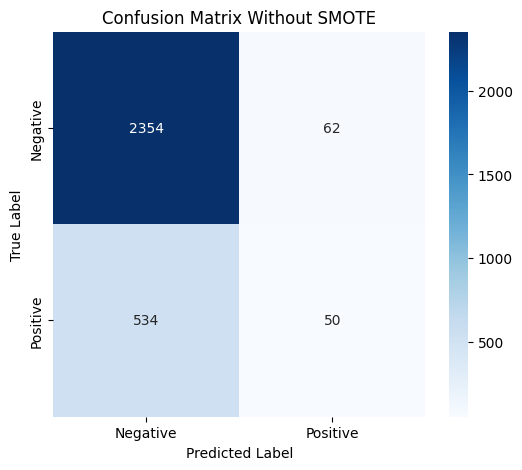

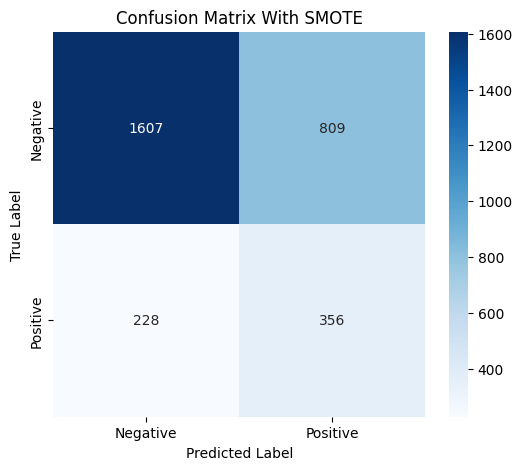

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(cm_ns, labels=['Negative', 'Positive'], title='Confusion Matrix Without SMOTE')
plot_confusion_matrix(cm_s, labels=['Negative', 'Positive'], title='Confusion Matrix With SMOTE')



In [ ]:
# Print True Positive percentages
print(f"True Positive Percentage Without SMOTE: {tp_percentage_ns:.2f}%")
print(f"True Positive Percentage With SMOTE: {tp_percentage_s:.2f}%")

True Positive Percentage Without SMOTE: 8.56%
True Positive Percentage With SMOTE: 60.96%


Impact of SMOTE: The large increase in the True Positive Percentage (from 8.56% to 60.96%) suggests that SMOTE significantly improved the model's ability to correctly identify positive instances. This is likely because SMOTE generated synthetic positive samples, addressing the class imbalance problem